# Spam or Ham - RNN Edition
Lab Assignment Eight: Recurrent Neural Networks

**_Jake Oien, Seung Ki Lee, Jenn Le_**

## Business Understanding

### Dataset Description

This dataset contains raw text messages that were classified as either spam or ham, as in not spam. Collecting and analyzing this data can be useful for identifying the characteristics of spam messages and in turn, assist in filtering out spam in text messages as well as emails. Individuals and groups are being more frequently targeting consumers through their text messages as the medium is more personal than email and this can cause people to lower their guards. Being able to recognize the patterns prevalent in a spam message can help avoid possibly harmful situations that can be caused by these spam messages.

The texts that make up this dataset come from free sources on the internet, including 425 messages from the Grumbletext Web Site, 3,375 from the NUS SMS Corpus (NSC), 450 from Caroline Tag's PhD Thesis, and 1,325 from the SMS Spam Corpus v.0.1 Big.

### Business Case

Our algorithm might be used in an opt-in service provided by a cell network. If a user gets targeted by a bunch of spam messages, they may want to have some service available that will prematurely detect a spam message coming in and not allow it to reach them. Analysis of the message text could help with that. An ideal use case of this system would mean that every spam message gets captured and every ham message makes it through. This may not be entirely possible, so the system should err on the side of allowing spam messages in if it means that every ham message makes it in. 

## Preparation

First, we will load the dataset. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Here, we'll import the data, remove unwanted columns(cause this data has 3 empty columns for some reason,
# and rename the columns to be more descriptive
data = pd.read_csv("./spam.csv", encoding='latin-1')
data = data.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
data = data.rename(columns={"v1":"label", "v2":"text"})

data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Verify Data Quality

To clean up the data set, we've analyzed what words were meaningless in the context of constituting a message. First major filler we've noticed was the markdown tags. We concluded words such as **& lt;#& gt;** are used for formatting purposes and not for anything pertinent to the meaning of the text. Also, we did not come across any words which started with '&' and ended with ';' which wasn't a markdown tag, so the probability of removing important data seems very low. 

In [2]:
#verify data quality
import re

#remove irrelavant words : markdown tags
data.text.replace(to_replace=["#?\&(lt|gt)\;"],value=[''],regex=True, inplace=True)  # get rid of &lt; type encodings


We should add a column which stores the length of a text, which will be useful later. 

In [3]:
length = lambda x: len(x)
data["text_length"] = data["text"].map(length)  # add a column indicating how long a message is
data.head(10)

,label,text,text_length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61
5,spam,FreeMsg Hey there darling it's been 3 week's n...,148
6,ham,Even my brother is not like to speak with me. ...,77
7,ham,As per your request 'Melle Melle (Oru Minnamin...,160
8,spam,WINNER!! As a valued network customer you have...,158
9,spam,Had your mobile 11 months or more? U R entitle...,154


Now let's remove duplicate texts from the dataset.

In [4]:
# data[data.label == "spam"].text.values[0:7]
len_data = len(data)
data.drop_duplicates(inplace=True)
len_data_no_dupes = len(data)

print("Number of total text messages: {}".format(len_data))
print("Number of unique text messages: {}".format(len_data_no_dupes))
print("Number of duplicates removed: {}".format(len_data - len_data_no_dupes))

Number of total text messages: 5572
Number of unique text messages: 5169
Number of duplicates removed: 403


We see that we removed 403 duplicate messages from the dataset. Now let's visualize a sparse representation of the messages. 

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
pd.options.display.max_columns = 1000

#create bag of words
count_vector = CountVectorizer(stop_words=None)
bag_of_words = count_vector.fit_transform(data['text'])

#put word counts in pd.DataFrame
bag_of_words_df = pd.DataFrame(data=bag_of_words.toarray(), 
                                       columns=count_vector.get_feature_names())

bag_of_words_df.head()

,00,000,000pes,008704050406,0089,0121,01223585236,01223585334,0125698789,02,0207,02072069400,02073162414,02085076972,021,03,04,0430,05,050703,0578,06,07,07008009200,07046744435,07090201529,07090298926,07099833605,07123456789,0721072,07732584351,07734396839,07742676969,07753741225,0776xxxxxxx,07781482378,07786200117,077xxx,078,07801543489,07808,07808247860,07808726822,07815296484,07821230901,078498,07880867867,0789xxxxxxx,07946746291,0796xxxxxx,07973788240,07xxxxxxxxx,08,0800,08000407165,08000776320,08000839402,08000930705,08000938767,08001950382,08002888812,08002986030,08002986906,08002988890,08006344447,0808,08081263000,08081560665,0825,083,0844,08448350055,08448714184,0845,08450542832,08452810071,08452810073,08452810075over18,0870,08700435505150p,08700469649,08700621170150p,08701213186,08701237397,08701417012,08701417012150p,0870141701216,087016248,08701752560,087018728737,0870241182716,08702490080,08702840625,08704050406,08704439680,08704439680ts,08706091795,0870737910216yrs,08707500020,08707509020,0870753331018,08707808226,08708034412,08708800282,08709222922,08709501522,0871,087104711148,08712101358,08712103738,0871212025016,08712300220,087123002209am,08712317606,08712400200,08712400602450p,08712400603,08712402050,08712402578,08712402779,08712402902,08712402972,08712404000,08712405020,08712405022,08712460324,08712466669,0871277810710p,0871277810810,0871277810910p,08714342399,087147123779am,08714712379,08714712388,08714712394,08714712412,08714714011,08715203028,08715203649,08715203652,08715203656,08715203677,08715203685,08715203694,08715205273,08715500022,08715705022,08717111821,08717168528,08717205546,0871750,08717507382,08717509990,08717890890å,08717895698,08717898035,08718711108,08718720201,08718723815,08718725756,08718726270,087187262701,08718726970,08718726971,08718726978,087187272008,08718727868,08718727870,08718727870150ppm,08718730555,08718730666,08718738001,08718738002,08718738034,08719180219,08719180248,08719181259,08719181503,08719181513,08719839835,08719899217,08719899229,08719899230,09,09041940223,09050000301,09050000332,09050000460,09050000555,09050000878,09050000928,09050001295,09050001808,09050002311,09050003091,09050005321,09050090044,09050280520,09053750005,09056242159,09057039994,09058091854,09058091870,09058094454,09058094455,09058094507,09058094565,09058094583,09058094594,09058094597,09058094599,09058095107,09058095201,09058097189,09058097218,09058098002,09058099801,09061104276,09061104283,09061209465,09061213237,09061221061,09061221066,09061701444,09061701461,09061701851,09061701939,09061702893,09061743386,09061743806,09061743810,09061743811,09061744553,09061749602,09061790121,09061790125,09061790126,09063440451,09063442151,09063458130,0906346330,09064011000,09064012103,09064012160,09064015307,09064017295,09064017305,09064018838,09064019014,09064019788,09065069120,09065069154,09065171142,09065174042,09065394514,09065394973,09065989180,09065989182,09066350750,09066358152,09066358361,09066361921,09066362206,09066362220,09066362231,09066364311,09066364349,09066364589,09066368327,09066368470,09066368753,09066380611,09066382422,09066612661,09066649731from,09066660100,09071512432,09071512433,09071517866,09077818151,09090204448,09090900040,09094100151,09094646631,09094646899,09095350301,09096102316,09099725823,09099726395,09099726429,09099726481,09099726553,09111030116,09111032124,09701213186,0a,0quit,10,100,1000,1000call,1000s,100p,100percent,100txt,1013,1030,10am,10k,10p,10ppm,10th,11,1120,113,1131,114,116,1172,118p,11mths,11pm,12,1205,120p,121,1225,123,125,1250,125gift,128,12hours,12hrs,12mths,13,130,1327,139,14,140,1405,140ppm,145,1450,146tf150p,14tcr,14thmarch,15,150,1500,150p,150p16,150pm,150ppermesssubscription,150ppm,150ppmpobox10183bhamb64xe,150ppmsg,150pw,151,153,15541,15pm,16,165,1680,169,177,18,180,1843,18p,18yrs,195,1956669,1apple,1b6a5ecef91ff9,1cup,1da,1er,1hr,1im,1lemon,1mega,1million,1pm,1st,1st4terms,1stchoice,1stone,1thing,1tulsi,1win150ppmx3,1winaweek,1winawk,1x150p,1yf,20,200,2000,2003,20

First, at the end of the list, we see a lot of strange characters. We don't know what these characters are, but they likely come from an encoding mismatch. Without that knowledge, we will leave them in for now, until we can understand better what the characters mean. 

Second, at the beginning of the list, we see a lot of numbers that have 10+ digits. These are likely phone numbers. Depending how we want to set up our sequences, we may wish to replace all of these long strings with a single identifier. This might be helpful because a specific phone number doesn't necessarily mean anything different than the presence of a phone number. A neural network might determine that a phone number in a message from a specific area code might mean more than another phone number for a spam classification. However, we have less than 1,000 spam messages to look at, so a first intuition seems that any specific phone numbers/area codes might not be well-represented enough to be used as a sufficient means of classification. 

### Evaluation Metric

How do we determine the success of our neural network? We will consider spam to be our positive class. At the end of the day, we care about finding spam messages and not misclassifying ham messages. Therefore, it seems that the F1 score would be our best metric for evaluation. 

When a message is spam, we want to correctly classify it, so we want to include recall. However, if a message is always classified as spam, we will have 100% recall, which means that we will have 100% recall and 0% messages making it to the recipient. So, we also want to include a measure that takes into account correct predictions. We don't care about successfully classifying ham messages, rather, we care about not misclassifying them. In that case, we want precision. Because we want to include both precision and recall, we will use the F1 score to get the best of both worlds. 

### Cross Validation Method

Now, how will we try to estimate generalization performance? We will use K-fold cross validation but we want to make sure we have enough examples of spam in each fold. Should we use a stratified method? Let's look at the class distribution. 

In [6]:
data_grouped = data.groupby(by="label")  # separate ham and spam
# sns.barplot(x="label", y="count", data=data_grouped.text)
count = data_grouped.text.count()  # just the count of all entries
ax = count.plot(kind="barh")
plt.xlabel("count")
plt.title("Count of spam and ham messages");

Yes, we should use a stratified method, because there is a big class imbalance. We will use 5-fold stratified cross-validation because 10-fold took too long.

## Modeling (50 points total)
### [25 points] Investigate at least two different recurrent network architectures (perhaps LSTM and GRU). Adjust hyper-parameters of the networks as needed to improve generalization performance. 
### [25 points] Use the method of cross validation and evaluation metric that you argued for at the beginning of the lab. Visualize the best results of the RNNs.   


In [6]:
# import everything
import numpy as np

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU

Using TensorFlow backend.


In [7]:
texts = data.text.as_matrix()
labels = data.label.as_matrix()
labels_nums = data.label.astype("category").cat.codes.as_matrix()  # numerical representation of the labels

In [8]:
NUM_TOP_WORDS = None
MAX_TEXT_LEN = 500 # maximum and minimum number of words

tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

X = pad_sequences(sequences, maxlen=MAX_TEXT_LEN)
y = labels_nums

y_ohe = keras.utils.to_categorical(labels_nums)
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y_ohe.shape)
print(np.max(X))

Found 8920 unique tokens. Distilled to 8920 top words.
Shape of data tensor: (5169, 500)
Shape of label tensor: (5169, 2)
8920


Now we will load the Glove embedding.  TODO maybe make it trainable?

In [10]:
%%time
EMBED_SIZE = 100
# the embed size should match the file you load glove from
embeddings_index = {}
with open('glove/glove.6B.100d.txt') as f:
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))
        
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)

Found 400000 word vectors.
(8921, 100)
CPU times: user 10.4 s, sys: 335 ms, total: 10.8 s
Wall time: 10.8 s


Now let's make a basic RNN using the LSTM model. 

In [11]:
from keras.layers import Embedding


embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],
                            input_length=MAX_TEXT_LEN,
                            trainable=False)

In [12]:
from sklearn.model_selection import train_test_split
# Split it into train / test subsets
X_train, X_test, y_train_ohe, y_test_ohe = train_test_split(X, y_ohe, test_size=0.2,
                                                            stratify=labels, 
                                                            random_state=42)
NUM_CLASSES = 2
print(X_train.shape,y_train_ohe.shape)
print(np.sum(y_train_ohe,axis=0))

(4135, 500) (4135, 2)
[ 3613.   522.]


In [13]:
def create_lstm_model(dropout, recurrent_dropout):
    rnn_lstm = Sequential()
    rnn_lstm.add(embedding_layer)
    rnn_lstm.add(LSTM(100,dropout=dropout, recurrent_dropout=recurrent_dropout))
    rnn_lstm.add(Dense(NUM_CLASSES, activation='sigmoid'))
    rnn_lstm.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
    
    return rnn_lstm
#     print(rnn_lstm.summary())

In [14]:
# rnn_lstm.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=3, batch_size=64)

Now let's try it with a GRU model. 

In [15]:
def create_gru_model(dropout, recurrent_dropout):
    rnn_gru = Sequential()
    rnn_gru.add(embedding_layer)
    rnn_gru.add(GRU(100,dropout=dropout, recurrent_dropout=recurrent_dropout))
    rnn_gru.add(Dense(NUM_CLASSES, activation='sigmoid'))
    rnn_gru.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
    
    return rnn_gru
#     print(rnn_gru.summary())

In [53]:
# rnn_gru.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=3, batch_size=64)

Train on 4135 samples, validate on 1034 samples
Epoch 1/3
4135/4135 [==============================] - 77s - loss: 0.2723 - acc: 0.8927 - val_loss: 0.1253 - val_acc: 0.9603
Epoch 2/3
4135/4135 [==============================] - 75s - loss: 0.1160 - acc: 0.9637 - val_loss: 0.0907 - val_acc: 0.9676
Epoch 3/3
4135/4135 [==============================] - 73s - loss: 0.0814 - acc: 0.9726 - val_loss: 0.0859 - val_acc: 0.9695


Now let's tune some hyperparameters.

In [22]:
### TODO Don't run this cell ###

dropout_params = [0.1, 0.2, 0.3]
recurrent_dropout_params = dropout_params
models = {}

for dropout in dropout_params:
    for recurrent_dropout in recurrent_dropout_params:
        lstm_model = create_lstm_model(dropout, recurrent_dropout)
        gru_model = create_gru_model(dropout, recurrent_dropout)
        
        print(f"### LSTM Model Dropout: {dropout} Recurrent Dropout: {recurrent_dropout} ###")
        lstm_model.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=4, batch_size=64)
        print(f"### GRU Model Dropout: {dropout} Recurrent Dropout: {recurrent_dropout} ###")
        gru_model.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=4, batch_size=64)
        models[f"LSTM: dropout:{dropout}, recurrent_dropout:{recurrent_dropout}"] = lstm_model
        models[f"GRU: dropout:{dropout}, recurrent_dropout:{recurrent_dropout}"] = gru_model

        

### LSTM Model Dropout: 0.1 Recurrent Dropout: 0.1 ###
Train on 4135 samples, validate on 1034 samples
Epoch 1/4
4135/4135 [==============================] - 95s - loss: 0.2458 - acc: 0.9144 - val_loss: 0.1188 - val_acc: 0.9599
Epoch 2/4
4135/4135 [==============================] - 93s - loss: 0.1004 - acc: 0.9686 - val_loss: 0.0880 - val_acc: 0.9705
Epoch 3/4
4135/4135 [==============================] - 94s - loss: 0.0846 - acc: 0.9703 - val_loss: 0.0895 - val_acc: 0.9724
Epoch 4/4
4135/4135 [==============================] - 94s - loss: 0.0662 - acc: 0.9809 - val_loss: 0.0823 - val_acc: 0.9691
### GRU Model Dropout: 0.1 Recurrent Dropout: 0.1 ###
Train on 4135 samples, validate on 1034 samples
Epoch 1/4
4135/4135 [==============================] - 73s - loss: 0.2867 - acc: 0.8799 - val_loss: 0.1323 - val_acc: 0.9613
Epoch 2/4
4135/4135 [==============================] - 72s - loss: 0.1053 - acc: 0.9658 - val_loss: 0.0811 - val_acc: 0.9710
Epoch 3/4
4135/4135 [========================

4135/4135 [==============================] - 73s - loss: 0.0870 - acc: 0.9711 - val_loss: 0.0856 - val_acc: 0.9705
Epoch 4/4
4135/4135 [==============================] - 71s - loss: 0.0725 - acc: 0.9776 - val_loss: 0.0781 - val_acc: 0.9720
### LSTM Model Dropout: 0.3 Recurrent Dropout: 0.2 ###
Train on 4135 samples, validate on 1034 samples
Epoch 1/4
4135/4135 [==============================] - 100s - loss: 0.2723 - acc: 0.8956 - val_loss: 0.1214 - val_acc: 0.9574
Epoch 2/4
4135/4135 [==============================] - 94s - loss: 0.1289 - acc: 0.9550 - val_loss: 0.0933 - val_acc: 0.9666
Epoch 3/4
4135/4135 [==============================] - 94s - loss: 0.0962 - acc: 0.9675 - val_loss: 0.0854 - val_acc: 0.9666
Epoch 4/4
4135/4135 [==============================] - 93s - loss: 0.0865 - acc: 0.9709 - val_loss: 0.0884 - val_acc: 0.9691
### GRU Model Dropout: 0.3 Recurrent Dropout: 0.2 ###
Train on 4135 samples, validate on 1034 samples
Epoch 1/4
4135/4135 [==============================] -

We are going to pick the two combinations of dropout that achieved the highest validation accuracy, in addition to using the maximum dropout we fit on. We will be performing our cross validation metrics on these parameters. 

|Model Type|Dropout|Recurrent Dropout|
|--|--|--|
|GRU|0.2|0.2|
|GRU|0.2|0.3|
|GRU|0.3|0.3|

In [20]:
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import EarlyStopping
num_folds = 5
dropout = 0.2
recurrent_dropout = 0.2
scores = {"model0": [], "model1": [], "model2": []}
skf = StratifiedKFold(n_splits=num_folds, shuffle=True)

param_list = [[0.2, 0.2], [0.2, 0.3], [0.3, 0.3]]

In [22]:
for model_num, params in enumerate(param_list):
    for i, (train, test) in enumerate(skf.split(X, y)):
        print (params)
        model = create_gru_model(params[0], params[1])
        model.fit(X[train], y_ohe[train], 
                  epochs=7, 
                  validation_data=(X[test], y_ohe[test]), 
                  callbacks=[EarlyStopping(monitor='val_loss', patience=2)],
                  batch_size=64
                 )
        yhat = np.argmax(model.predict(X[test]), axis=1)
        score = f1_score(y[test],yhat)
        scores[f"model{model_num}"].append(score)

[0.2, 0.2]
Train on 4134 samples, validate on 1035 samples
Epoch 1/7
4134/4134 [==============================] - 67s - loss: 0.2877 - acc: 0.8835 - val_loss: 0.1513 - val_acc: 0.9575
Epoch 2/7
4134/4134 [==============================] - 71s - loss: 0.1148 - acc: 0.9648 - val_loss: 0.0864 - val_acc: 0.9729
Epoch 3/7
4134/4134 [==============================] - 68s - loss: 0.0839 - acc: 0.9723 - val_loss: 0.0706 - val_acc: 0.9763
Epoch 4/7
4134/4134 [==============================] - 69s - loss: 0.0708 - acc: 0.9770 - val_loss: 0.0735 - val_acc: 0.9768
Epoch 5/7
4134/4134 [==============================] - 69s - loss: 0.0641 - acc: 0.9777 - val_loss: 0.0626 - val_acc: 0.9792
Epoch 6/7
4134/4134 [==============================] - 68s - loss: 0.0521 - acc: 0.9834 - val_loss: 0.0614 - val_acc: 0.9821
Epoch 7/7
4134/4134 [==============================] - 78s - loss: 0.0552 - acc: 0.9828 - val_loss: 0.0594 - val_acc: 0.9816
[0.2, 0.2]
Train on 4135 samples, validate on 1034 samples
Epoch 1

4136/4136 [==============================] - 64s - loss: 0.0625 - acc: 0.9813 - val_loss: 0.0505 - val_acc: 0.9797
Epoch 7/7
4136/4136 [==============================] - 64s - loss: 0.0628 - acc: 0.9809 - val_loss: 0.0469 - val_acc: 0.9816
[0.2, 0.3]
Train on 4136 samples, validate on 1033 samples
Epoch 1/7
4136/4136 [==============================] - 64s - loss: 0.2862 - acc: 0.8804 - val_loss: 0.1529 - val_acc: 0.9545
Epoch 2/7
4136/4136 [==============================] - 64s - loss: 0.1225 - acc: 0.9594 - val_loss: 0.0941 - val_acc: 0.9666
Epoch 3/7
4136/4136 [==============================] - 64s - loss: 0.0896 - acc: 0.9712 - val_loss: 0.0768 - val_acc: 0.9777
Epoch 4/7
4136/4136 [==============================] - 64s - loss: 0.0728 - acc: 0.9740 - val_loss: 0.0670 - val_acc: 0.9831
Epoch 5/7
4136/4136 [==============================] - 63s - loss: 0.0639 - acc: 0.9788 - val_loss: 0.0732 - val_acc: 0.9782
Epoch 6/7
4136/4136 [==============================] - 64s - loss: 0.0626 - 

In [23]:
print(scores)

{'model0': [0.92800000000000005, 0.93680297397769519, 0.92125984251968507, 0.90421455938697315, 0.95019157088122619], 'model1': [0.92307692307692313, 0.92490118577075098, 0.88188976377952744, 0.93129770992366412, 0.92244897959183669], 'model2': [0.91406250000000011, 0.90980392156862744, 0.92369477911646591, 0.93333333333333335, 0.93599999999999994]}


## Compare Models

In [196]:
# from the output
gru_2_2_score = [0.92800000000000005, 0.93680297397769519, 0.92125984251968507, 0.90421455938697315, 0.95019157088122619]
gru_2_3_score = [0.92307692307692313, 0.92490118577075098, 0.88188976377952744, 0.93129770992366412, 0.92244897959183669]
gru_3_3_score = [0.91406250000000011, 0.90980392156862744, 0.92369477911646591, 0.93333333333333335, 0.93599999999999994]

arr_gru_2_2 = np.asarray(model0_score, dtype=np.float32)
arr_gru_2_3 = np.asarray(model1_score, dtype=np.float32)
arr_gru_3_3 = np.asarray(model2_score, dtype=np.float32)

# gru_2_2 vs gru_2_3
t = 2.26/np.sqrt(10)
e = (1-arr_gru_2_2)-(1-arr_gru_2_3)
stdtot = np.std(e)
dbar = np.mean(e)
print('(0.2/0.2 to 0.2/0.3) Range of: ', dbar-t*stdtot,' , ', dbar+t*stdtot)

# gru_2_3 vs gru_3_3
t = 2.26/np.sqrt(10)
e = (1-arr_gru_2_3)-(1-arr_gru_3_3)
stdtot = np.std(e)
dbar = np.mean(e)
print('(0.2/0.3 to 0.3/0.3) Range of: ', dbar-t*stdtot,' , ', dbar+t*stdtot)

# gru_2_2 vs gru_3_3
t = 2.26/np.sqrt(10)
e = (1-arr_gru_2_2)-(1-arr_gru_3_3)
stdtot = np.std(e)
dbar = np.mean(e)
print('(0.2/0.2 to 0.3/0.3) Range of: ', dbar-t*stdtot,' , ', dbar+t*stdtot)

print('========================================================================')

print("Score +- StdDev for 0.2/0.2: {} +/- {}".format(np.mean(arr_gru_2_2), np.std(arr_gru_2_2)))
print("Max Score for 0.2/0.2: {}".format(np.max(arr_gru_2_2)))
print("Score +- StdDev for 0.2/0.3: {} +/- {}".format(np.mean(arr_gru_2_3), np.std(arr_gru_2_3)))
print("Max Score for 0.2/0.2: {}".format(np.max(arr_gru_2_3)))
print("Score +- StdDev for 0.3/0.3: {} +/- {}".format(np.mean(arr_gru_3_3), np.std(arr_gru_3_3)))
print("Max Score for 0.2/0.2: {}".format(np.max(arr_gru_3_3)))

(0.2/0.2 to 0.2/0.3) Range of:  -0.0275817136084  ,  0.00483998980271
(0.2/0.3 to 0.3/0.3) Range of:  -0.00771984543478  ,  0.0210318275896
(0.2/0.2 to 0.3/0.3) Range of:  -0.0185259847208  ,  0.00909624400128
Score +- StdDev for 0.2/0.2: 0.9280937910079956 +/- 0.015369391068816185
Max Score for 0.2/0.2: 0.9501915574073792
Score +- StdDev for 0.2/0.3: 0.9167229533195496 +/- 0.017696434631943703
Max Score for 0.2/0.2: 0.9312977194786072
Score +- StdDev for 0.3/0.3: 0.9233789443969727 +/- 0.010291333310306072
Max Score for 0.2/0.2: 0.9359999895095825


It seems that Model0, or GRU with dropout=0.2 and recurrent_dropout=0.2 has the best performance in terms of average and Maximum recall score. The max f1 score amounts to 95.02% for GRU 0.2/0.2, and the averge of 92.81% which is 0.5% higher than the next highest f1.

## Visualize the Results

Let's use a overlapping bar charts to see which model has the highest score.

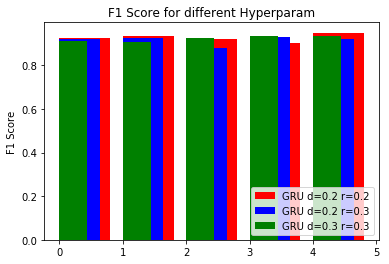

In [260]:
import matplotlib.pyplot as plt

width = 0.8
indices = np.arange(len(gru_2_2_score))

plt.bar(indices, gru_2_2_score, width=width, color='r', label="GRU d=0.2 r=0.2", align="edge")
plt.bar(indices, gru_2_3_score, width=0.8*width, color='b', label="GRU d=0.2 r=0.3", align="edge")
plt.bar(indices,gru_3_3_score, width=0.55*width, color='g', label="GRU d=0.3 r=0.3", align="edge")

plt.legend(loc=4)
plt.ylabel("F1 Score")
plt.title("F1 Score for different Hyperparam")
plt.show()

In this overlapping bar chart, we know that the color that's on the top represents the highest scores. While we can see which model has the best score at each point, it is difficult to see at a glance exact score of a model. Let's plot another graph.

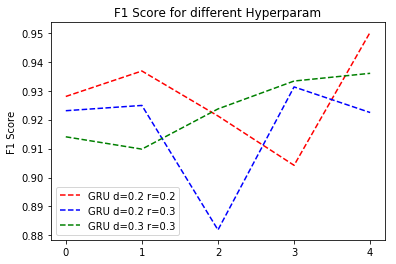

In [262]:
import matplotlib.pyplot as plt

indices = np.arange(len(gru_2_2_score))

ax = plt.subplot()
plt.plot(indices, gru_2_2_score, 'r--', label="GRU d=0.2 r=0.2")
plt.plot(indices, gru_2_3_score, 'b--', label="GRU d=0.2 r=0.3")
plt.plot(indices, gru_3_3_score, 'g--', label="GRU d=0.3 r=0.3")

plt.legend()
plt.ylabel("F1 Score")
plt.xticks([0,1,2,3,4])

plt.title("F1 Score for different Hyperparam")
plt.show()

We can easily see that GRU with dropout=0.2 and reccurent_dropout=0.2 performs the best at all points except for one fold of the test. Our best parameter is dropout=0.2 and recurrent_dropout=0.2

## Exceptional Work (10 points total)
### One idea (required for 7000 level students): Train an embedding layer for words in your RNN. Visualize and interpret the embedding layer weights. 
### Another Idea (NOT required): Try to create a RNN for generating novel text. 

We tried generating a rnn generator for text messages instead of novel. With help of two websites :
https://chunml.github.io/ChunML.github.io/project/Creating-Text-Generator-Using-Recurrent-Neural-Network/
https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/

Let's see if this works.

In [1]:
#!/usr/bin/env python
import numpy
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout
from keras.layers import GRU
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

# read in file
file = "./hamspam.txt"
textdata = open(file).read()
chars = list(set(textdata))
num_char = len(textdata)
num_vocab = len(chars)

# mapping
char_to_ix = dict((c, i) for i, c in enumerate(chars))
ix_to_char = dict((i, c) for i, c in enumerate(chars))


X = numpy.reshape(X_data, (num_pattern, seq_length, 1))
y = np_utils.to_categorical(y_data)

# define and train with gru model
rnn = Sequential()
rnn.add(GRU(10, input_shape=(X.shape[1], X.shape[2])))
rnn.add(Dropout(0.2))
rnn.add(Dense(y.shape[1], activation='sigmoid'))
rnn.compile(loss='categorical_crossentropy', optimizer='adam')

# test with large batch size to reduce training time
rnn.fit(X, y, epochs=1, batch_size=256, callbacks=callbacks_list)

# seed 
seed = numpy.random.randint(0, len(dataX)-1)
pattern = dataX[seed]
print("Seed:")
print("\"", ''.join([int_to_char[value] for value in pattern]), "\"")

# Write
f = open("this_is_spam.txt", "w")
for i in range(50):
    x = numpy.reshape(pattern, (1, len(pattern), 1))
    prediction = rnn.predict(x, verbose=0)
    index = numpy.argmax(prediction)
    result = ix_to_char[index]
    f.write(result)
print("\n")
print("End of File")

f.close()

Unfortunately we could not get the generator to work, especially because of the long training time.